In [45]:
import pandas as pd

In [46]:
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")
airlines_passengers = pd.read_csv("international-airline-passengers.csv")

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
all_series = {
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "International airline passengers: monthly totals in thousands": airlines_passengers['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'],
}

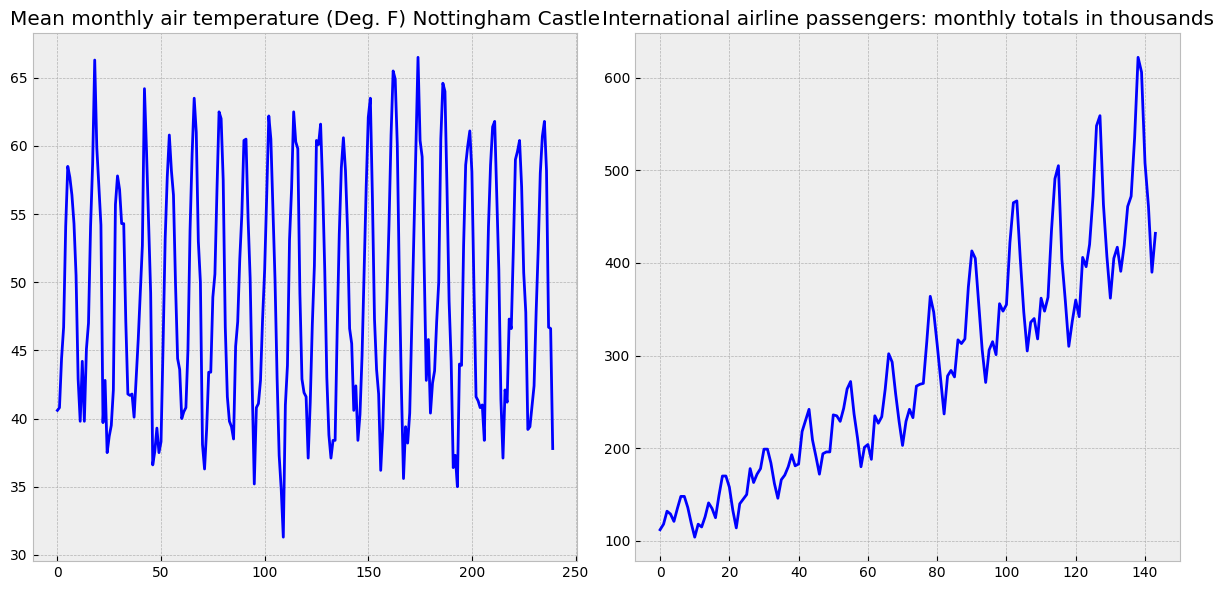

In [49]:
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 6))
    layout = (1, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

In [50]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

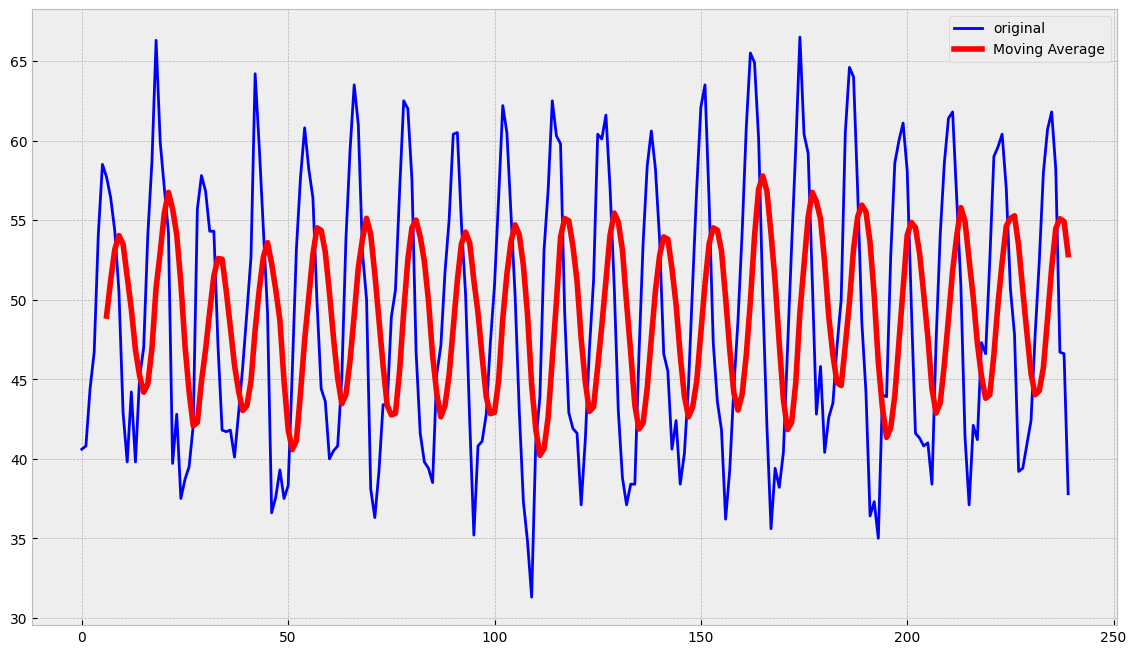

In [51]:
mean_monthly = moving_average(mean_monthly_temp["Deg"], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(mean_monthly_temp['Deg'], color='blue',label='original')
    plt.plot(mean_monthly, color='red', linewidth='4', label='Moving Average')
    plt.legend()

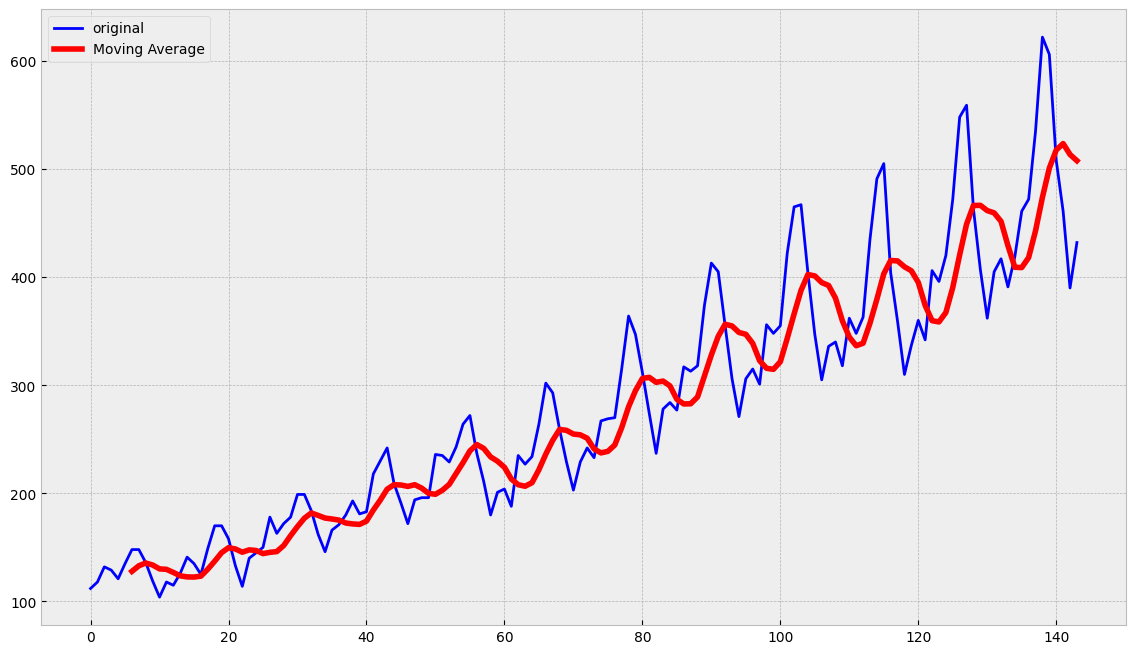

In [52]:
air_passengers = moving_average(airlines_passengers['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(airlines_passengers['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], color='blue',label='original')
    plt.plot(air_passengers, color='red', linewidth='4', label='Moving Average')
    plt.legend()

К моему счастью, здесь невооруженным взлядом видна линия тренда на втором графике.
Хотя в первом можно скорее всего еще улучшить. Если ее провести, то скорее всего она пройдет горизонтально.